In [48]:
#!/usr/bin/env python

# CONUS404_pr-changes.ipynb

In [49]:
'''File name: CONUS404_pr-changes.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 19.05.2022
    Date last modified: 19.05.2022

    ############################################################## 
    Purpos:

    - Rean in hourly precipitation data from CONUS404 
    - Save the data at lower precission to make it easier accessible
    - Calculate changes in the hourly precipitation distribution 

'''

'File name: CONUS404_pr-changes.ipynb\n    Author: Andreas Prein\n    E-mail: prein@ucar.edu\n    Date created: 19.05.2022\n    Date last modified: 19.05.2022\n\n    ############################################################## \n    Purpos:\n\n    - Rean in hourly precipitation data from CONUS404 \n    - Save the data at lower precission to make it easier accessible\n    - Calculate changes in the hourly precipitation distribution \n\n'

In [50]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import os
from pdb import set_trace as stop
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import label
from matplotlib import cm
from scipy import ndimage
import random
import scipy
import pickle
import datetime
import pandas as pd
import subprocess
from calendar import monthrange
import pandas as pd
import datetime
import sys 
import shapefile as shp
import matplotlib.path as mplPath
from scipy.stats import norm
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from calendar import monthrange
from tqdm import tqdm
import xarray as xr

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cf

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

#### speed up interpolation
import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np

def interp_weights(xy, uv,d=2):
    tri = qhull.Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)

def deiscretice_timeseries(DATA,
                          bucked_size):
#     Discrete_timeseries = np.copy(DATA); Discrete_timeseries[:] = np.nan
#     for tt in range(len(DATA)):
#         if ~np.isnan(DATA[tt]) == True:   
#             INT, REST = divmod(DATA[tt], bucked_size)
#             Discrete_timeseries[tt] = INT * bucked_size
#             if tt != len(DATA)-1:
#                 DATA[tt+1] = DATA[tt+1]+REST
#     return Discrete_timeseries

    if len(DATA.shape) == 1:
        # make data 2D
        DATA = DATA[:,None]
    Discrete_timeseries = np.copy(DATA); Discrete_timeseries[:] = np.nan
    for tt in tqdm(range(DATA.shape[0])):
        INT, REST = np.apply_along_axis(np.divmod, 0, DATA[tt,:], bucked_size)
        FIN = ~np.isnan(INT)
        Discrete_timeseries[tt,:] = INT * bucked_size
        if tt != len(DATA)-1:
            DATA[tt+1,FIN] = DATA[tt+1,FIN]+REST[FIN]
    return Discrete_timeseries

In [51]:
# ================================
# BUKOFSKY REGION
# Add the subregions
import geopandas as gpd
from tqdm import tqdm

REGIONS = [ 'Appalachia.shp',
            'CPlains.shp',
            'DeepSouth.shp',
            'GreatBasin.shp',
            'GreatLakes.shp',
            'Mezquital.shp',
            'MidAtlantic.shp',
            'NorthAtlantic.shp',
            'NPlains.shp',
            'NRockies.shp',
            'PacificNW.shp',
            'PacificSW.shp',
            'Prairie.shp',
            'Southeast.shp',
            'Southwest.shp',
            'SPlains.shp',
            'SRockies.shp']

REGIONS_names = [ 'Appalachia',
            'Central Plains',
            'Deep South',
            'Great Basin',
            'Great Lakes',
            'Mezquital',
            'Mid-Atlantic',
            'North-Atlantic',
            'Northern Plains',
            'Northern Rockies',
            'Pacific Northwest',
            'Pacific Southwest',
            'Prairie',
            'Southeast',
            'Southwest',
            'Southern Plains',
            'Southern Rockies']

In [52]:
##############################################################
#                READ CONUS404 CONSTANT FIELDS
sLon='XLONG'
sLat='XLAT'
sOro='HGT'
sLSM='LANDMASK'
sPlotDir = ''
GEO_EM_D1 = '/glade/campaign/ncar/USGS_Water/CONUS404/wrfconstants_d01_1979-10-01_00:00:00.nc4'

ncid=Dataset(GEO_EM_D1, mode='r') # open the netcdf
Lon=np.squeeze(ncid.variables[sLon][:])
Lat=np.squeeze(ncid.variables[sLat][:])
Height4=np.squeeze(ncid.variables[sOro][:])
LSM=np.squeeze(ncid.variables[sLSM][:])
ncid.close()

In [53]:
DataFolder = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/'
SaveFolder = '/glade/campaign/mmm/c3we/prein/CONUS404/data/CONUS404_processed_data/'

StartDay = datetime.datetime(1980, 1, 1, 0)
StopDay = datetime.datetime(2019, 12, 31, 23)
TimeHH = pd.date_range(StartDay, end=StopDay, freq='1h')
TimeMM = pd.date_range(StartDay, end=StopDay, freq='M')
Years = np.unique(TimeMM.year)

Seasons = ['MJJASO','May-Jun','Jul-Aug','Sep-Oct']
# rgiSeasons = [range(1,13,1),
#                  [1,2,12],
#                  [3,4,5],
#                  [6,7,8],
#                  [9,10,11]]

rgiSeasons = [[5,6,7,8,9,10],
                 [5,6],
                 [7,8],
                 [9,10]]

dry_threshold = 0.05 # mm/h

In [54]:
MaskFile = 'Burkofski_Regions_CONUS404.npz'
if os.path.exists(MaskFile) == False:
    rgiStatsInBasins = []
    MaskStations = np.zeros((Lon.shape[0],Lon.shape[1])); MaskStations[:] = np.nan
    rgrGridCells=[(Lon.flatten()[ii],Lat.flatten()[ii]) for ii in range(len(Lon.flatten()))]
    for re in tqdm(range(len(REGIONS))):
        data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
        Coordinates = data['geometry']
        for sf in range(len(data)):
            TEST = np.array(Coordinates[sf].exterior.coords.xy)
            ctr=TEST.T
            grPRregion=mplPath.Path(ctr)
            TMP=np.array(grPRregion.contains_points(rgrGridCells))
        TMP = np.reshape(TMP, (Lon.shape[0], Lon.shape[1]))
        MaskStations[TMP==1] = re+1
    #     MaskStations = np.append(MaskStations,[re+1]*len(iStationSelect))
    MaskStations = MaskStations.astype('int')
    
    np.savez(MaskFile,
            MaskStations = MaskStations,
            Lon = Lon,
            Lat = Lat)
else:
    DATA = np.load(MaskFile)
    MaskStations = DATA['MaskStations']
    Lon = DATA['Lon']
    Lat = DATA['Lat']
MaskStations[MaskStations < 0] = 0

Region_indices = ndimage.find_objects(MaskStations)
# Region_indices = ndimage.find_objects(MaskStations)

### READ HOURLY CONUS404 PRECIPITATION DATA

In [55]:
Save_file = SaveFolder+'PREC_ACC_NC_'+str(TimeMM[0].year)+str(TimeMM[0].month).zfill(2)+'-'+str(TimeMM[-1].year)+str(TimeMM[-1].month).zfill(2)+'.npz'

if os.path.exists(Save_file) == False:
    CONUS404_hourly_pr = np.zeros((len(TimeHH), Lon.shape[0], Lon.shape[1]), dtype=np.float16)
    for mm in tqdm(range(len(TimeMM))):
        YYYY = TimeMM[mm].year
        MM = TimeMM[mm].month
        rgiHours = (TimeHH.year == YYYY) & (TimeHH.month == MM)
        File_act = DataFolder + 'PREC_ACC_NC_'+str(YYYY)+str(MM).zfill(2)+'_CONUS404.nc'
        ncid=Dataset(File_act, mode='r') # open the netcdf
        CONUS404_hourly_pr[rgiHours,:,:] = np.array(np.squeeze(ncid.variables['PREC_ACC_NC'][:]), dtype=np.float16)
        ncid.close()
        np.savez(Save_file,
            CONUS404_hourly_pr = CONUS404_hourly_pr,
            TimeHH = TimeHH,
            Lon = Lon,
            Lat = Lat)
else:
    print('Load data from '+Save_file)
#     DATA = np.load(Save_file)
#     CONUS404_hourly_pr = DATA['CONUS404_hourly_pr']
#     TimeHH = pd.to_datetime(DATA['TimeHH'])
#     Lon = DATA['Lon']
#     Lat = DATA['Lat']

Load data from /glade/campaign/mmm/c3we/prein/CONUS404/data/CONUS404_processed_data/PREC_ACC_NC_198001-201912.npz


### Read CDFs from preprocessed files
The preprocessed files are created by running - papers/2021_Hist-Ext-PR-Changes/programs/CONUS404_pr-changes/CONUS404_pr-bin_preprocessor.py

In [56]:
se = 3
rgiHH_season = np.isin(TimeHH.month, rgiSeasons[se])
Time_se = TimeHH[rgiHH_season]

In [57]:
# load preprocessed data
for yy in tqdm(range(len(Years))):
    time_string = str(Years[yy])+'_'+Seasons[se]
    File = '/glade/campaign/mmm/c3we/prein/CONUS404/data/CONUS404_processed_data/CONUS404_bined_pr/PREC_ACC_NC_'+time_string+'.nc'
    ncid=Dataset(File, mode='r') # open the netcdf
    precipitation = np.squeeze(ncid.variables['precipitation'][:])
    ncid.close()
    if yy == 0:
        CONUS404_bined_pr = np.zeros((len(Years), precipitation.shape[0], Lon.shape[0], Lon.shape[1]), dtype=np.float32)
    CONUS404_bined_pr[yy,-precipitation.shape[0]:,:,:] = precipitation[:,:,:]

100%|██████████| 40/40 [00:46<00:00,  1.16s/it]


In [58]:
# load annual peak hourly precipitation
for yy in tqdm(range(len(Years))):
    time_string = str(Years[yy])+'_'+Seasons[se]
    File = '/glade/campaign/mmm/c3we/prein/CONUS404/data/CONUS404_processed_data/CONUS404_an-seas_max-PR/Max_PREC_ACC_NC_'+time_string+'.nc'
    ncid=Dataset(File, mode='r') # open the netcdf
    precipitation = np.squeeze(ncid.variables['max_precipitation'][:])
    ncid.close()
    if yy == 0:
        CONUS404_extr_pr = np.zeros((len(Years), Lon.shape[0], Lon.shape[1]), dtype=np.float32)
    CONUS404_extr_pr[yy,:,:] = precipitation

100%|██████████| 40/40 [00:02<00:00, 19.88it/s]


In [59]:
# Calculate trends in dry hours
dry_hour_freq = np.array([np.sum(CONUS404_bined_pr[yy,:,:,:] < dry_threshold, axis = 0) for yy in range(CONUS404_bined_pr.shape[0])])*10
trend_dry_hours = np.zeros((Lon.shape[0],Lon.shape[1], 5)); trend_dry_hours[:] = np.nan
for la in tqdm(range(Lon.shape[0])):
    for lo in range(Lon.shape[1]):
        trend_dry_hours[la,lo,:] = stats.linregress(Years, dry_hour_freq[:,la,lo])
dry_hour_freq_rel = (np.mean(dry_hour_freq, axis=0)/(CONUS404_bined_pr.shape[1]*10)) * 100

100%|██████████| 1015/1015 [05:28<00:00,  3.09it/s]


In [60]:
# Calculate trends in mean precipitation
mean_preciptation = np.array([np.mean(CONUS404_bined_pr[yy,:,:,:], axis = 0) for yy in range(CONUS404_bined_pr.shape[0])])
trend_mean_pr = np.zeros((Lon.shape[0],Lon.shape[1], 5)); trend_mean_pr[:] = np.nan
for la in tqdm(range(Lon.shape[0])):
    for lo in range(Lon.shape[1]):
        trend_mean_pr[la,lo,:] = stats.linregress(Years, mean_preciptation[:,la,lo])

100%|██████████| 1015/1015 [05:44<00:00,  2.95it/s]


In [61]:
# # Calculate trends in extreme precipitation
# extreme_preciptation = CONUS404_bined_pr[:,-1,:,:]
# trend_extreme_pr = np.zeros((Lon.shape[0],Lon.shape[1], 5)); trend_extreme_pr[:] = np.nan
# for la in tqdm(range(Lon.shape[0])):
#     for lo in range(Lon.shape[1]):
#         trend_extreme_pr[la,lo,:] = stats.linregress(Years, extreme_preciptation[:,la,lo])

In [62]:
# Calculate trends in annual peak precipitation
an_max_preciptation = CONUS404_extr_pr
trend_an_max_pr = np.zeros((Lon.shape[0],Lon.shape[1], 5)); trend_an_max_pr[:] = np.nan
for la in tqdm(range(Lon.shape[0])):
    for lo in range(Lon.shape[1]):
        trend_an_max_pr[la,lo,:] = stats.linregress(Years, an_max_preciptation[:,la,lo])

100%|██████████| 1015/1015 [05:40<00:00,  2.98it/s]


### Plot precipitation characteristics and their changes

In [63]:
# Define color tables
PR_Fraction = ['#ffffff','#afdbef','#5a96c6','#64ab5f','#eadf6d','#e9813d','#c93d35','#962722',
              '#7a0177','#c51b8a','#f768a1','#fa9fb5','#fcc5c0']#,'#ea43f1']
MeanPR    = np.linspace(0,0.24,len(PR_Fraction)) #np.array([0,10,20,30,40,50,60,70,80,85,90,95])
ExtremePR = np.linspace(0,72,len(PR_Fraction))

dry_freq_col = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061'][::-1]
dry_col_lev = np.linspace(80,100,len(dry_freq_col))

dry_col_trend = np.linspace(-0.6,0.6,len(dry_freq_col))

meanPR_col_trend = np.linspace(-10,10,len(dry_freq_col))

extremePR_col_trend = np.linspace(-20,20,len(dry_freq_col))

### Calculate the fractional contribution of precipitation as a function of intensity
### and linear trends for each precipitation bin

In [64]:
NN = 100
bins = np.array([0]+ [np.exp(np.log(0.005) + (ii* ((np.log(120)-np.log(0.005))**2/(NN)) )**0.5 ) for ii in range(NN)])
bins_cent = (bins[1:]+bins[:-1])/2
bins_width = bins[1:] - bins[:-1]

#### Load the pre-processed fractional contribution statistics
This is done in papers/2021_Hist-Ext-PR-Changes/programs/CONUS404_pr-changes/Fractional_Contribution/Fractional_Contribution_dataprocessing.py

In [65]:
DATA = np.load(SaveFolder+'Fractional_Contribution_changes.npz')
pr_frac_contributions = DATA['pr_frac_contributions']
REGIONS_names = DATA['REGIONS_names']
bins = DATA['bins']
bootstratp_nr = DATA['bootstratp_nr']
SampleSize = DATA['SampleSize']

In [66]:
# # Calculate fractional contribution of precipitation
# bootstratp_nr = 100
# pr_frac_contributions = np.zeros((NN, 2, bootstratp_nr, len(REGIONS))); pr_frac_contributions[:] = np.nan
# import random
# half_rec_len = int(CONUS404_hourly_pr.shape[0]/2)
# SampleSize = 2000

# for re in range(len(REGIONS)):
#     print('work on '+REGIONS[re])
#     for bs in tqdm(range(bootstratp_nr)):
#         for pe in range(2):
#             if pe == 0:
#                 sample = random.sample(range(0, half_rec_len), SampleSize)
#             elif pe == 1:
#                 sample = random.sample(range(half_rec_len, CONUS404_hourly_pr.shape[0]-1), SampleSize)
            
#             DATA_test = CONUS404_hourly_pr[sample,Region_indices[re][0].start:Region_indices[re][0].stop, 
#                   Region_indices[re][1].start:Region_indices[re][1].stop] 
#             DATA_test = np.array(DATA_test[:, MaskStations[Region_indices[re]] == re+1].flatten(), dtype=np.float32)
#             pr_frac_contributions[:,pe,bs,re] = np.array([np.sum(DATA_test[(DATA_test >= bins[ii]) & (DATA_test <= bins[ii+1])]) for ii in range(len(bins)-1)])

In [67]:
# # Calculate trends for regional averages
# rgrPR_Trends_SR = np.zeros((CONUS404_bined_pr.shape[1], 5, len(REGIONS))); rgrPR_Trends_SR[:] = np.nan
# xaxis_mean_pr = np.zeros((CONUS404_bined_pr.shape[1], len(REGIONS))); xaxis_mean_pr[:] = np.nan
# for re in tqdm(range(len(REGIONS))):
#     # calculate changes in bins
#     DATA_test = CONUS404_bined_pr[:,:,Region_indices[re][0].start:Region_indices[re][0].stop, 
#                   Region_indices[re][1].start:Region_indices[re][1].stop] 
#     # print(DATA_test.shape)
#     DATA_test = np.nanmean(DATA_test[:,:, MaskStations[Region_indices[re]] == re+1], axis=(2))
#     for pp in range(DATA_test.shape[1]):
#         if np.sum(DATA_test[:,pp]) != 0:
#             rgrPR_Trends_SR[pp,:,re] = stats.linregress(Years, DATA_test[:,pp])
#     rgrPR_Trends_SR[:,0,re] = rgrPR_Trends_SR[:,0,re]
#     xaxis_mean_pr[:,re] = np.mean(DATA_test, axis=0)

In [68]:
# fig = plt.figure(figsize=(18,18))
# rgsLableABC=list(string.ascii_lowercase)
# plt.rcParams.update({'font.size': 13})
# gs1 = gridspec.GridSpec(5,4)
# gs1.update(left=0.05, right=0.97,
#            bottom=0.05, top=0.98,
#            wspace=0.20, hspace=0.30)

# XX = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
# YY = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4]
# for re in range(len(REGIONS_names)):
#     ax = plt.subplot(gs1[YY[re],XX[re]])
    
#     ### plot linear trends in bins
#     MeanPR = xaxis_mean_pr[:,re]
#     # plt.plot(MeanPR[Wet], (rgrPR_Trends[300,1000,Wet,0]/MeanPR[Wet])*1000)
#     plt.plot(MeanPR, (rgrPR_Trends_SR[:,0,re]/MeanPR)*1000, c='k')
#     SIG = rgrPR_Trends_SR[:,3,re] <= 0.1
#     plt.scatter(MeanPR[SIG], ((rgrPR_Trends_SR[:,0,re]/MeanPR)*1000)[SIG], c='k')
#     ax.set_xscale('log')
#     plt.axhline(y=0, color='k', linestyle='-', lw=0.75)
#     if XX[re] == 0:
#         ax.set_ylabel('trend [% decade$^{-1}$]')
#     if (YY[re] == 4) | ((YY[re] == 3) & (XX[re] > 0)):
#         ax.set_xlabel('precipitation [mm h$^{-1}$]')
    
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)

#     plt.xlim((0.05,40))
#     plt.ylim((-8,20))
    
#     plt.title(r"$\bf{" + rgsLableABC[re] + ")}$ "+REGIONS_names[re])
    
# # # -----------------------
# # # plot an overview map showing the region locaations
# # ax = plt.subplot(gs1[4,1:4], projection=cart_proj)
# # import geopandas as gpd
# # ncfile = Dataset('/glade/u/home/prein/projects/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc')
# # HGT_M = getvar(ncfile, "HGT_M")
# # cart_proj = get_cartopy(HGT_M)
# # ncid.close()
# # for re in range(len(REGIONS)):
# #     data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
# #     Coordinates = data['geometry']
# #     for sf in range(len(data)):
# #         TEST = np.array(Coordinates[sf].exterior.coords.xy)
# #         TEST=TEST.T
# #         plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)
# #         # label the region
# #         XX = np.mean(TEST[:,0])
# #         YY = np.mean(TEST[:,1])
# #         plt.text(XX,YY, r"$\bf{" + rgsLableABC[re] + "}$", transform=ccrs.PlateCarree(), color='k', fontsize=15, ha='center',va='center')
        
# # plt.axis('off')
# # ax.coastlines(lw=0.5, alpha=0.5)
# # ax.add_feature(cf.BORDERS, lw=0.5, alpha=0.5)
# # ax.add_feature(cf.STATES, lw=0.5, alpha=0.5)

# sPlotFile=sPlotDir
# sPlotName= 'Linear-trends_pr-bins_Regions_'+Seasons[se]+'.pdf'
# if os.path.isdir(sPlotFile) != 1:
#     subprocess.call(["mkdir","-p",sPlotFile])
# print( '        Plot map to: '+sPlotFile+sPlotName)
# fig.savefig(sPlotFile+sPlotName) #, dpi=700)

work on Appalachia.shp
work on CPlains.shp
work on DeepSouth.shp
work on GreatBasin.shp
work on GreatLakes.shp
work on Mezquital.shp
work on MidAtlantic.shp
work on NorthAtlantic.shp
work on NPlains.shp
work on NRockies.shp
work on PacificNW.shp
work on PacificSW.shp
work on Prairie.shp
work on Southeast.shp
work on Southwest.shp
work on SPlains.shp
work on SRockies.shp
        Plot map to: Fractional-Contribution-Changes_Sep-Oct.pdf


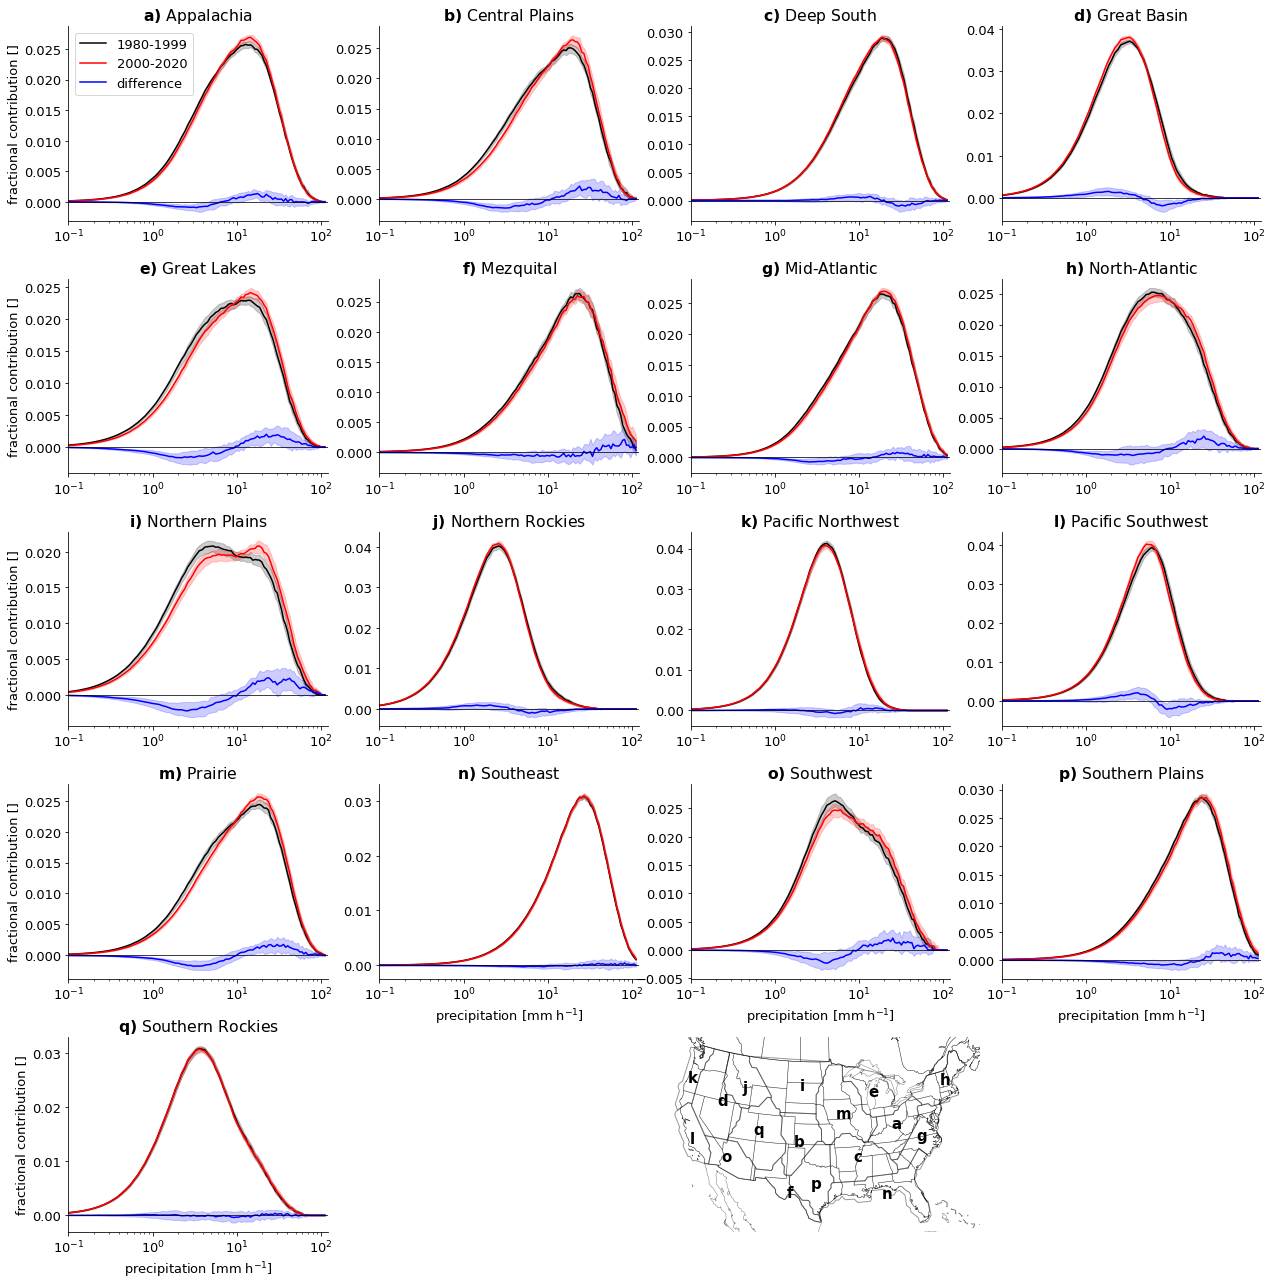

In [69]:
fig = plt.figure(figsize=(18,18))
rgsLableABC=list(string.ascii_lowercase)
plt.rcParams.update({'font.size': 13})
gs1 = gridspec.GridSpec(5,4)
gs1.update(left=0.05, right=0.97,
           bottom=0.05, top=0.98,
           wspace=0.20, hspace=0.30)

XX = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
YY = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4]
for re in range(len(REGIONS_names)):
    ax = plt.subplot(gs1[YY[re],XX[re]])
    
    print('work on '+REGIONS[re])
    Contribution = np.median(pr_frac_contributions[:,0,:,re]*bins_width[:,None]/np.sum(pr_frac_contributions[:,0,:,re]*bins_width[:,None], axis=0), axis=1)
    cont_spread = np.percentile(pr_frac_contributions[:,0,:,re]*bins_width[:,None]/np.sum(pr_frac_contributions[:,0,:,re]*bins_width[:,None], axis=0), (25,75),  axis=1)
#     cont_spread = cont_spread*bins_width[None,:]/np.sum(cont_spread*bins_width[None,:], axis=1)[:,None]
    plt.plot(bins_cent, Contribution, c='k', label = '1980-1999')
    plt.fill_between(bins_cent, cont_spread[0,:], y2=cont_spread[1,:], color='k', alpha=0.2)

    Contribution1 = np.median(pr_frac_contributions[:,1,:,re]*bins_width[:,None]/np.sum(pr_frac_contributions[:,1,:,re]*bins_width[:,None], axis=0), axis=1)
    cont_spread1 = np.percentile(pr_frac_contributions[:,1,:,re]*bins_width[:,None]/np.sum(pr_frac_contributions[:,1,:,re]*bins_width[:,None], axis=0), (25,75),  axis=1)
    # cont_spread1 = cont_spread1*bins_width/np.sum(cont_spread1*bins_width, axis=1)[:,None]
    plt.plot(bins_cent, Contribution1, c='r', label = '2000-2020')
    plt.fill_between(bins_cent, cont_spread1[0,:], y2=cont_spread1[1,:], color='r', alpha=0.2)
    
    diff_all = (pr_frac_contributions[:,1,:,re]*bins_width[:,None]/np.sum(pr_frac_contributions[:,1,:,re]*bins_width[:,None], axis=0))-\
            (pr_frac_contributions[:,0,:,re]*bins_width[:,None]/np.sum(pr_frac_contributions[:,0,:,re]*bins_width[:,None], axis=0))
    plt.plot(bins_cent, np.median(diff_all, axis=1), c='b', label = 'difference')
    
    plt.fill_between(bins_cent, np.percentile(diff_all, 75, axis=1), y2=np.percentile(diff_all, 25, axis=1), color='b', alpha=0.2)
    ax.set_xscale('log')

    plt.axhline(y=0, color='k', linestyle='-', lw=0.75)
    if XX[re] == 0:
        ax.set_ylabel('fractional contribution []')
    if (YY[re] == 4) | ((YY[re] == 3) & (XX[re] > 0)):
        ax.set_xlabel('precipitation [mm h$^{-1}$]')
        
    if re == 0:
        plt.legend()
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.xlim((0.1,120))
#     plt.ylim((-12,8))
    
    plt.title(r"$\bf{" + rgsLableABC[re] + ")}$ "+REGIONS_names[re])
    
# -----------------------
# plot an overview map showing the region locaations
import geopandas as gpd
ncfile = Dataset('/glade/u/home/prein/projects/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc')
HGT_M = getvar(ncfile, "HGT_M")
cart_proj = get_cartopy(HGT_M)
ncfile.close()
ax = plt.subplot(gs1[4,1:4], projection=cart_proj)
for re in range(len(REGIONS)):
    data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
    Coordinates = data['geometry']
    for sf in range(len(data)):
        TEST = np.array(Coordinates[sf].exterior.coords.xy)
        TEST=TEST.T
        plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)
        # label the region
        XX = np.mean(TEST[:,0])
        YY = np.mean(TEST[:,1])
        plt.text(XX,YY, r"$\bf{" + rgsLableABC[re] + "}$", transform=ccrs.PlateCarree(), color='k', fontsize=15, ha='center',va='center')
        
plt.axis('off')
ax.coastlines(lw=0.5, alpha=0.5)
ax.add_feature(cf.BORDERS, lw=0.5, alpha=0.5)
ax.add_feature(cf.STATES, lw=0.5, alpha=0.5)

sPlotFile=sPlotDir
sPlotName= 'Fractional-Contribution-Changes_'+Seasons[se]+'.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName) #, dpi=700)

### Puplication ready plot

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not

        Plot map to: CONUS404_pr-characteristic_maps_fractional-pr-changes_Sep-Oct.jpg


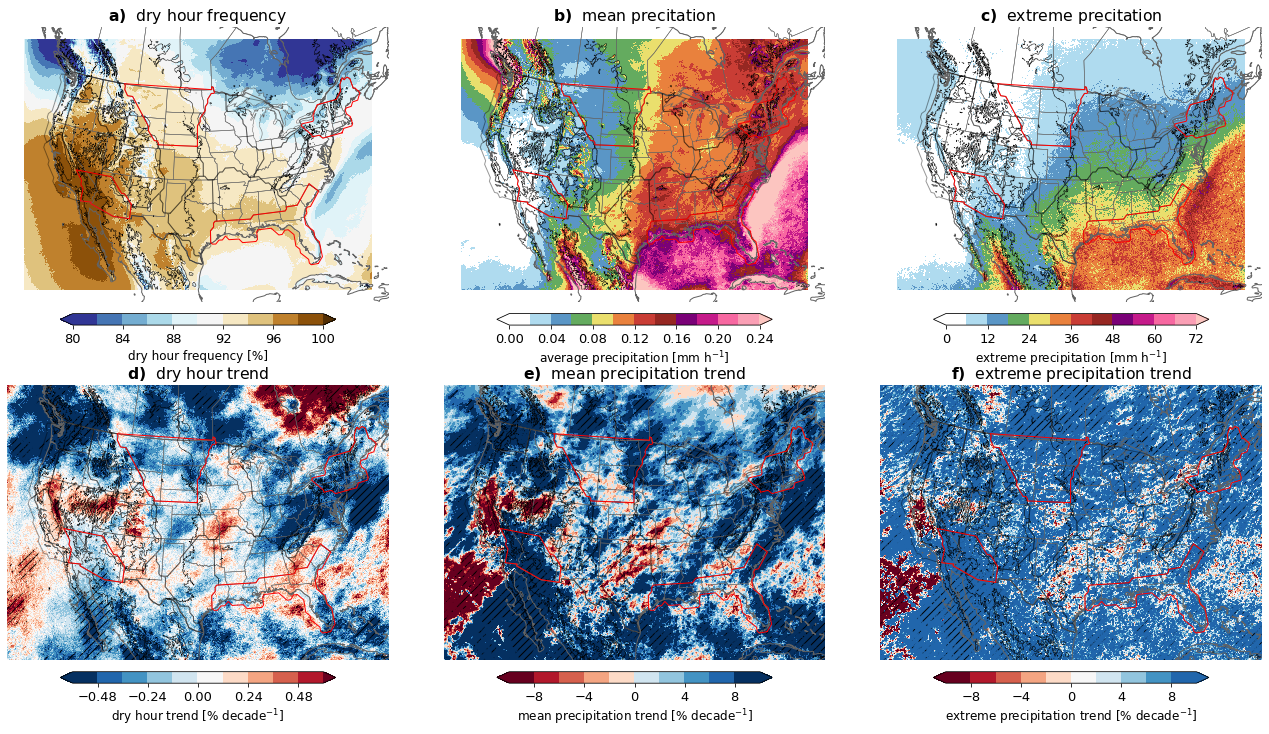

In [70]:
ncfile = Dataset(GEO_EM_D1)
HGT_M = getvar(ncfile, "HGT")
cart_proj = get_cartopy(HGT_M)
ncfile.close()

from matplotlib import colors as c


CB = 50 # grid cells removed from boundary
key_regions = [7,13,8,14]

fig = plt.figure(figsize=(18,16))
rgsLableABC=list(string.ascii_lowercase)
plt.rcParams.update({'font.size': 13})
gs1 = gridspec.GridSpec(2,3)
gs1.update(left=0.01, right=0.99,
           bottom=0.35, top=0.9,
           wspace=0.1, hspace=0.3)

# -------------------------
# dry hour frequency
ax = plt.subplot(gs1[0,0], projection=cart_proj)
pos1 = ax.get_position()
cMap = c.ListedColormap(dry_freq_col)
cMap = c.ListedColormap(['#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3','#f5f5f5','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695'][::-1])
cs = plt.pcolormesh(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], dry_hour_freq_rel[CB:-CB,CB:-CB], cmap=cMap, 
                    norm = mpl.colors.BoundaryNorm(dry_col_lev, ncolors=len(dry_col_lev)-1, clip=False),
                    transform=ccrs.PlateCarree())
# cs = plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], dry_hour_freq_rel[CB:-CB,CB:-CB], levels = np.linspace(80,100,21), extend='both', cmap='coolwarm', transform=ccrs.PlateCarree())
plt.contour(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], Height4[CB:-CB,CB:-CB], levels = (500, 2000), colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
ax.coastlines(color='#636363')
ax.add_feature(cf.BORDERS, edgecolor='#636363')
ax.add_feature(cf.STATES, lw=0.5, edgecolor='#636363')
plt.axis('off')
plt.title(r"$\bf{" + rgsLableABC[0] + ")}$ "+' dry hour frequency')

# Plot bukofsky retions in addition
for re in range(len(REGIONS)):
    data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
    Coordinates = data['geometry']
    for sf in range(len(data)):
        TEST = np.array(Coordinates[sf].exterior.coords.xy)
        TEST=TEST.T
        if REGIONS[re] in np.array(REGIONS)[key_regions]:
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='r', transform=ccrs.PlateCarree(), alpha=1, zorder=10)
        else:
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)

CbarAx = axes([pos1.x0, pos1.y0-0.02, pos1.width, 0.01])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
# cb.ax.set_xticklabels(LEVS,rotation=90)
cb.set_label('dry hour frequency [%]', fontsize=12)     




# -------------------------
# average precipitation
ax = plt.subplot(gs1[0,1], projection=cart_proj)
pos1 = ax.get_position()
cMap = c.ListedColormap(PR_Fraction)

# cs = plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], np.mean(mean_preciptation[:,CB:-CB,CB:-CB], axis=0), levels = MeanPR, extend='max', colors=PR_Fraction, transform=ccrs.PlateCarree())
cs = plt.pcolormesh(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], np.mean(mean_preciptation[:,CB:-CB,CB:-CB], axis=0), cmap=cMap, 
                    norm = mpl.colors.BoundaryNorm(MeanPR, ncolors=len(MeanPR)-1, clip=False),
                    transform=ccrs.PlateCarree())
plt.contour(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], Height4[CB:-CB,CB:-CB], levels = (500, 2000), colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
ax.coastlines(color='#636363')
ax.add_feature(cf.BORDERS, edgecolor='#636363')
ax.add_feature(cf.STATES, lw=0.5, edgecolor='#636363')
plt.axis('off')
plt.title(r"$\bf{" + rgsLableABC[1] + ")}$ "+' mean precitation')

# Plot bukofsky retions in addition
for re in range(len(REGIONS)):
    data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
    Coordinates = data['geometry']
    for sf in range(len(data)):
        TEST = np.array(Coordinates[sf].exterior.coords.xy)
        TEST=TEST.T
        if REGIONS[re] in np.array(REGIONS)[key_regions]:
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='r', transform=ccrs.PlateCarree(), alpha=1, zorder=10)
        else:
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)
            
CbarAx = axes([pos1.x0, pos1.y0-0.02, pos1.width, 0.01])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
# cb.ax.set_xticklabels(LEVS,rotation=90)
cb.set_label('average precipitation [mm h$^{-1}$]', fontsize=12)  


# -------------------------
# extreme precipitation
ax = plt.subplot(gs1[0,2], projection=cart_proj)
pos1 = ax.get_position()

# cs = plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], np.mean(CONUS404_bined_pr[:,-1,CB:-CB,CB:-CB], axis=0), levels = ExtremePR, extend='max', colors=PR_Fraction, transform=ccrs.PlateCarree())
cs = plt.pcolormesh(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], np.mean(CONUS404_extr_pr[:,CB:-CB,CB:-CB], axis=0), cmap=cMap, 
                    norm = mpl.colors.BoundaryNorm(ExtremePR, ncolors=len(ExtremePR)-1, clip=False),
                    transform=ccrs.PlateCarree())
plt.contour(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], Height4[CB:-CB,CB:-CB], levels = (500, 2000), colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
ax.coastlines(color='#636363')
ax.add_feature(cf.BORDERS, edgecolor='#636363')
ax.add_feature(cf.STATES, lw=0.5, edgecolor='#636363')
plt.axis('off')
plt.title(r"$\bf{" + rgsLableABC[2] + ")}$ "+' extreme precitation')

# Plot bukofsky retions in addition
for re in range(len(REGIONS)):
    data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
    Coordinates = data['geometry']
    for sf in range(len(data)):
        TEST = np.array(Coordinates[sf].exterior.coords.xy)
        TEST=TEST.T
        if REGIONS[re] in np.array(REGIONS)[key_regions]:
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='r', transform=ccrs.PlateCarree(), alpha=1, zorder=10)
        else:
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)

CbarAx = axes([pos1.x0, pos1.y0-0.02, pos1.width, 0.01])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
# cb.ax.set_xticklabels(LEVS,rotation=90)
cb.set_label('extreme precipitation [mm h$^{-1}$]', fontsize=12)  


# -------------------------
# dry hour trends
ax = plt.subplot(gs1[1,0], projection=cart_proj)
pos1 = ax.get_position()
cMap = c.ListedColormap(dry_freq_col)
dry_hour_rel_trend_decade = (trend_dry_hours[:,:,0] / np.mean(dry_hour_freq, axis=0)) * 100 * 10

cs = plt.pcolormesh(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], dry_hour_rel_trend_decade[CB:-CB,CB:-CB], cmap=cMap, 
                    norm = mpl.colors.BoundaryNorm(dry_col_trend, ncolors=len(dry_col_trend)-1, clip=False),
                    transform=ccrs.PlateCarree())
plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], trend_dry_hours[CB:-CB,CB:-CB,3], levels=[0,0.1, 1], hatches=['///', None], alpha=0, transform=ccrs.PlateCarree(), transform_first=True)

# cs = plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], dry_hour_freq_rel[CB:-CB,CB:-CB], levels = np.linspace(80,100,21), extend='both', cmap='coolwarm', transform=ccrs.PlateCarree())
plt.contour(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], Height4[CB:-CB,CB:-CB], levels = (500, 2000), colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
ax.coastlines(color='#636363')
ax.add_feature(cf.BORDERS, edgecolor='#636363')
ax.add_feature(cf.STATES, lw=0.5, edgecolor='#636363')
plt.axis('off')
plt.title(r"$\bf{" + rgsLableABC[3] + ")}$ "+' dry hour trend')

# Plot bukofsky retions in addition
for re in range(len(REGIONS)):
    data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
    Coordinates = data['geometry']
    for sf in range(len(data)):
        TEST = np.array(Coordinates[sf].exterior.coords.xy)
        TEST=TEST.T
        if REGIONS[re] in np.array(REGIONS)[key_regions]:
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='r', transform=ccrs.PlateCarree(), alpha=1, zorder=10)
        else:
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)
            
CbarAx = axes([pos1.x0, pos1.y0-0.02, pos1.width, 0.01])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
# cb.ax.set_xticklabels(LEVS,rotation=90)
cb.set_label('dry hour trend [% decade$^{-1}$]', fontsize=12)


# -------------------------
# mean precipitation trends
ax = plt.subplot(gs1[1,1], projection=cart_proj)
pos1 = ax.get_position()
cMap = c.ListedColormap(dry_freq_col[::-1])
mean_pr_rel_trend_decade = (trend_mean_pr[:,:,0] / np.mean(mean_preciptation, axis=0)) * 100 * 10

# cs = plt.pcolormesh(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], mean_pr_rel_trend_decade[CB:-CB,CB:-CB], cmap=cMap, 
#                     norm = mpl.colors.BoundaryNorm(meanPR_col_trend, ncolors=len(meanPR_col_trend)-1, clip=False),
#                     transform=ccrs.PlateCarree())

cs = plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], mean_pr_rel_trend_decade[CB:-CB,CB:-CB], cmap=cMap, 
                    levels = meanPR_col_trend, transform=ccrs.PlateCarree(), extend = 'both')


plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], trend_mean_pr[CB:-CB,CB:-CB,3], 
             levels=[0,0.1, 1], hatches=['///', None], alpha=0, transform=ccrs.PlateCarree(), transform_first=True)

# cs = plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], dry_hour_freq_rel[CB:-CB,CB:-CB], levels = np.linspace(80,100,21), extend='both', cmap='coolwarm', transform=ccrs.PlateCarree())
plt.contour(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], Height4[CB:-CB,CB:-CB], levels = (500, 2000), colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
ax.coastlines(color='#636363')
ax.add_feature(cf.BORDERS, edgecolor='#636363')
ax.add_feature(cf.STATES, lw=0.5, edgecolor='#636363')
plt.axis('off')
plt.title(r"$\bf{" + rgsLableABC[4] + ")}$ "+' mean precipitation trend')

# Plot bukofsky retions in addition
for re in range(len(REGIONS)):
    data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
    Coordinates = data['geometry']
    for sf in range(len(data)):
        TEST = np.array(Coordinates[sf].exterior.coords.xy)
        TEST=TEST.T
        if REGIONS[re] in np.array(REGIONS)[key_regions]:
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='r', transform=ccrs.PlateCarree(), alpha=1, zorder=10)
        else:
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)
            
CbarAx = axes([pos1.x0, pos1.y0-0.02, pos1.width, 0.01])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
# cb.ax.set_xticklabels(LEVS,rotation=90)
cb.set_label('mean precipitation trend [% decade$^{-1}$]', fontsize=12)



# -------------------------
# annual maxima precipitation trends
ax = plt.subplot(gs1[1,2], projection=cart_proj)
pos1 = ax.get_position()
cMap = c.ListedColormap(dry_freq_col[::-1])
an_max_pr_rel_trend_decade = (trend_an_max_pr[:,:,0] / np.mean(an_max_preciptation, axis=0)) * 100 * 10

# cs = plt.pcolormesh(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], an_max_pr_rel_trend_decade[CB:-CB,CB:-CB], cmap=cMap, 
#                     norm = mpl.colors.BoundaryNorm(meanPR_col_trend, ncolors=len(meanPR_col_trend)-1, clip=False),
#                     transform=ccrs.PlateCarree())
cs = plt.contourf(Lon[CB:-CB,CB:-CB],Lat[CB:-CB,CB:-CB], an_max_pr_rel_trend_decade[CB:-CB,CB:-CB], levels = meanPR_col_trend, 
                  extend='both', colors=dry_freq_col[::-1], transform=ccrs.PlateCarree(), transform_first=True)
plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], trend_an_max_pr[CB:-CB,CB:-CB,3], levels=[0,0.1, 1], 
             hatches=['///', None], alpha=0, transform=ccrs.PlateCarree(), transform_first=True)

# cs = plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], dry_hour_freq_rel[CB:-CB,CB:-CB], levels = np.linspace(80,100,21), extend='both', cmap='coolwarm', transform=ccrs.PlateCarree())
plt.contour(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], Height4[CB:-CB,CB:-CB], levels = (500, 2000), colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
ax.coastlines(color='#636363')
ax.add_feature(cf.BORDERS, edgecolor='#636363')
ax.add_feature(cf.STATES, lw=0.5, edgecolor='#636363')
plt.axis('off')
plt.title(r"$\bf{" + rgsLableABC[5] + ")}$ "+' extreme precipitation trend')

# Plot bukofsky retions in addition
for re in range(len(REGIONS)):
    data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
    Coordinates = data['geometry']
    for sf in range(len(data)):
        TEST = np.array(Coordinates[sf].exterior.coords.xy)
        TEST=TEST.T
        if REGIONS[re] in np.array(REGIONS)[key_regions]:
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='r', transform=ccrs.PlateCarree(), alpha=1, zorder=10)
        else:
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)

CbarAx = axes([pos1.x0, pos1.y0-0.02, pos1.width, 0.01])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
# cb.ax.set_xticklabels(LEVS,rotation=90)
cb.set_label('extreme precipitation trend [% decade$^{-1}$]', fontsize=12)






# # ==============================
# # ==============================

# gs1 = gridspec.GridSpec(1,4)
# gs1.update(left=0.05, right=0.98,
#            bottom=0.05, top=0.25,
#            wspace=0.30, hspace=0.40)

# for re in range(len(key_regions)):
#     ax = plt.subplot(gs1[0,re])
    
#     print('work on '+REGIONS[key_regions[re]])
#     Contribution = np.median(pr_frac_contributions[:,0,:,key_regions[re]]*bins_width[:,None]/np.sum(pr_frac_contributions[:,0,:,key_regions[re]]*bins_width[:,None], axis=0), axis=1)
#     cont_spread = np.percentile(pr_frac_contributions[:,0,:,key_regions[re]]*bins_width[:,None]/np.sum(pr_frac_contributions[:,0,:,key_regions[re]]*bins_width[:,None], axis=0), (25,75),  axis=1)
# #     cont_spread = cont_spread*bins_width[None,:]/np.sum(cont_spread*bins_width[None,:], axis=1)[:,None]
#     plt.plot(bins_cent, Contribution, c='k', label = '1980-1999')
#     plt.fill_between(bins_cent, cont_spread[0,:], y2=cont_spread[1,:], color='k', alpha=0.2)

#     Contribution1 = np.median(pr_frac_contributions[:,1,:,key_regions[re]]*bins_width[:,None]/np.sum(pr_frac_contributions[:,1,:,key_regions[re]]*bins_width[:,None], axis=0), axis=1)
#     cont_spread1 = np.percentile(pr_frac_contributions[:,1,:,key_regions[re]]*bins_width[:,None]/np.sum(pr_frac_contributions[:,1,:,key_regions[re]]*bins_width[:,None], axis=0), (25,75),  axis=1)
#     # cont_spread1 = cont_spread1*bins_width/np.sum(cont_spread1*bins_width, axis=1)[:,None]
#     plt.plot(bins_cent, Contribution1, c='r', label = '2000-2020')
#     plt.fill_between(bins_cent, cont_spread1[0,:], y2=cont_spread1[1,:], color='r', alpha=0.2)
    
#     diff_all = (pr_frac_contributions[:,1,:,key_regions[re]]*bins_width[:,None]/np.sum(pr_frac_contributions[:,1,:,key_regions[re]]*bins_width[:,None], axis=0))-\
#             (pr_frac_contributions[:,0,:,key_regions[re]]*bins_width[:,None]/np.sum(pr_frac_contributions[:,0,:,key_regions[re]]*bins_width[:,None], axis=0))
#     plt.plot(bins_cent, np.median(diff_all, axis=1), c='b', label = 'difference')
    
#     plt.fill_between(bins_cent, np.percentile(diff_all, 75, axis=1), y2=np.percentile(diff_all, 25, axis=1), color='b', alpha=0.2)
#     ax.set_xscale('log')

#     plt.axhline(y=0, color='k', linestyle='-', lw=0.75)
#     if re == 0:
#         ax.set_ylabel('fractional contribution []')
#     ax.set_xlabel('precipitation [mm h$^{-1}$]')
        
#     if re == 1:
#         plt.legend()
    
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)

#     plt.xlim((0.15,160))
# #     plt.ylim((-12,8))
    
#     plt.title(r"$\bf{" + rgsLableABC[6+re] + ")}$ "+REGIONS_names[key_regions[re]])


sPlotFile=sPlotDir
sPlotName= 'CONUS404_pr-characteristic_maps_fractional-pr-changes_'+Seasons[se]+'.jpg'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)